<a href="https://colab.research.google.com/github/federicomoreno613/proyectos/blob/master/cv_uba_clase_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visión computacional basada en redes neuronales artificiales

# Unidad 3: Clasificación de imágenes
## Clase 11: Métodos de atribución


### 1. Configuración del ambiente

Vamos a montar nuestra unidad de Google Drive, primero, y a crear la carpeta donde colocaremos los datos auxiliares, en caso de que no exista.

In [ ]:
import torch
from google.colab import drive
from os import makedirs
from torchvision import transforms

# instalamos la librería wget usando pip
!pip install wget
# probamos si se instaló bien importándola
import wget

# montamos la unidad de Google Drive
drive.mount('/content/gdrive/')

# creamos la carpeta donde vamos a guardar los datos
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/'
makedirs(datasets_folder, exist_ok=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=8c69376249637b6b5ce4cc9c75f7214d14e902f05695408f2ea1bb8d784963fd
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


A lo largo de esta clase vamos a trabajar con una única imagen, a la que vamos a procesar como entrada para una ResNet. Esto implica que necesitamos ajustar su tamaño, recortar el centro para que quede de 224 x 244, convertirla en un tensor y normalizarla. Para poder visualizar los mapas de atribución exactamente sobre la imagen que usamos como entrada, vamos a separar entonces este conjunto de transformaciones según sean operaciones de imagen (```preprocessing_ops```) o de formateo (```preprocessing_format```).

In [ ]:
# preparamos las operaciones de transformación que se usaron para entrenar la red
preprocessing_ops = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224)])
# y las que se necesitan para preparar la entrada de la red
preprocessing_format = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Lo próximo será traernos las etiquetas de ImageNet, para usarlas cuando hagamos predicciones con la ResNet.

In [ ]:
import ast
from os import path

# borramos el archivo si ya está, lo descargamos de nuevo
!rm -rf /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/imagenet1000_clsidx*
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

# abrimos el archivo

with open(path.join(datasets_folder, 'imagenet1000_clsidx_to_labels.txt')) as reader:
  # lo leemos
  contents = reader.read()
  # lo volcamos en un diccionario
  image_net_labels = ast.literal_eval(contents)
  # imprimimos el diccionario
  print(image_net_labels)

--2022-09-05 19:27:46--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘/content/gdrive/My Drive/Colab Notebooks/Computer Vision/imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.002s  

2022-09-05 19:27:46 (15.3 MB/s) - ‘/content/gdrive/My Drive/Colab Notebooks/Computer Vision/imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4:

Y ahora vamos a levantar la imagen del perro y la vamos a preparar para usarla como entrada para la red.

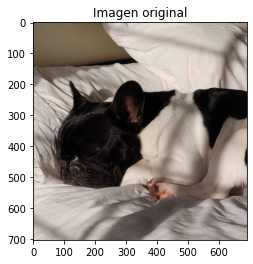

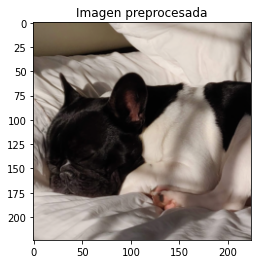

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# abrimos la imagen del perro
dog_image = Image.open(path.join(datasets_folder, 'dog.png'))
# le sacamos el canal alpha
dog_image = dog_image.convert("RGB")
# la mostramos
plt.imshow(dog_image)
plt.title("Imagen original")
plt.show()

# pasamos la imagen por las transformaciones para preprocesarla
preprocessed_dog_image = preprocessing_ops(dog_image)
# la mostramos por pantalla
plt.imshow(preprocessed_dog_image)
plt.title("Imagen preprocesada")
plt.show()
# formateamos la imagen para que quede lista para la red
image_as_tensor = preprocessing_format(preprocessed_dog_image)
# agregamos una coordenada extra para simular un batch size de 1
image_as_tensor = image_as_tensor.unsqueeze(0)


Como verán, tenemos dos variables creadas: una ```preprocessed_dog_image```, que es la imagen recortada y con el tamaño que la necesitamos, y una ```image_as_tensor```, que ya está convertida a tensor, normalizada y con la dimensión adicional que nos simula el batch. A la primera la vamos a usar como referencia cuando generemos los mapas de atribución, y a la segunda como entrada para la red.

### 2. Interpretando modelos con GradCAMs

Los modelos de clasificación es general son evaluados usando métricas como accuracy o F1-score, y analizando a ojo las coincidencias y los errores. Sin embargo, no tenemos garantías para asegurar que esos resultados sean realmente porque el modelo aprendió a entender las diferentes clases que queremos detectar, o porque tuvimos suerte. En algunos casos (sobre todo cuando la cantidad de datos de entrenamiento es muy limitada) puede pasar que el modelo en realidad haya "memorizado" alguna característica puntual de la imagen que sirva para resolver más o menos bien el problema. Por ejemplo: imaginemos que contamos con fotos de abejas y hormigas, pero que las fotos de hormigas fueron tomadas en un laboratorio, siempre contra un fondo blanco. La red puede terminar aprendiendo "fondo blanco es igual a hormiga", y empezar a romperse cuando traigamos fotos de hormigas tomadas en cualquier parte.

Contar con algoritmos para interpretar modelos de deep learning es básico para completar la fase de debuggeo. En modelos de machine learning clásico, podemos inferir qué features fueron las más útiles usando algunas técnicas como las de feature importance en Random Forest o los pesos de un regresor logístico. Sin embargo, en visión computacional con deep learning es un poco más complejo: ¿cómo hago para saber si la red estuvo mirando siempre el fondo de la imagen o se está enfocando en regiones que son más interesantes y que están vinculadas con el objeto en sí?

Para ello, muchxs investigadorxs han en el último tiempo diseñado estrategias que permiten recuperar, dado un modelo, una imagen y una determinada etiqueta, indicar qué píxeles de la imagen son tenidos en cuenta por el modelo para predecir esa clase dada. Es lo que se suele conocer en inglés como "Model interpretability".

Nosotros vamos a trabajar con una familia específica de este tipo de modelos, los Class Activation Maps, o CAMs. 

#### 2.1. Instalando TorchCAM

En particular, vamos a usar una librería nueva que se llama [TorchCAM](https://frgfm.github.io/torch-cam/index.html), que está bárbara porque es muy fácil de usar. Si les interesara usar algún otro método, como los mapas de oclusión, pueden recurrir a [Captum](https://captum.ai/), que aunque es un poco más fea les permite usar otros métodos alternativos.

Empezamos entonces instalando TorchCAM mediante PIP.

In [ ]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### 2.2. Un ejemplo de mapa de activación en TorchCAM

Ahora que ya instalamos TorchCAM, vamos a hacer una primera prueba.

Lo primero que haremos será crear una función que nos permita visualizar los resultados fácilmente. La función recibe como parámetro la imagen original 

In [ ]:
import cv2
import numpy as np
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask

def visualize_cam_torchcam(original_image, attributions, title=""):

  # convertimos la imagen a un arreglo de numpy
  orig_image = np.array(original_image)
  # cambiamos el tamaño de los atributos para que sean del mismo tamaño que la imagen
  att_resized = cv2.resize(attributions.squeeze().cpu().detach().numpy(), dsize=(orig_image.shape[1], orig_image.shape[0]))
  # montamos el mapa de atribuciones como un mapa transparente sobre la imagen
  result = overlay_mask(original_image, to_pil_image(att_resized, mode='F'), alpha=0.5)
  
  # mostramos el par imagen / imagen con mapa montado
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(10, 5)
  plt.tight_layout()
  ax[0].imshow(original_image)
  ax[1].imshow(result)    
  for i in range(len(ax)):
      ax[i].set_yticklabels([])
      ax[i].set_xticklabels([])
      ax[i].set_yticks([])
      ax[i].set_xticks([])
  plt.title(title)
  plt.show()


Ahora vamos a hacer la primera prueba de la librería. Primero tenemos que elegir qué método de atribución queremos usar. Hay muchos, que los pueden encontrar en [este link](https://frgfm.github.io/torch-cam/methods.html). Nosotros vamos a empezar hoy usando [GradCAM](https://www.youtube.com/watch?v=nBqdUAYxLjs), uno de los métodos más populares hoy día para estudiar atribuciones de los modelos.

Para ello, debemos crear primero un objeto de la clase ```GradCAM```, que debe conocer el modelo (en modo evaluación, y antes de que lo hayamos usado para predecir cualquier cosa) y también los nombres de los puntos de la red que se utilizarán para calcular el mapa de activaciones. 

Veamos un poco este último punto. Una ResNet puede representarse gráficamente como en la siguiente figura:

![](https://i.imgur.com/XwcnU5x.png)

Bajémonos la ResNet18 preentrenada en ImageNet y visualicemos su estructura:


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# nos traemos la red con los pesos entrenados en ImageNet
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

GradCAM nos permite generar visualizaciones para cualquier capa que nosotros le pidamos. Pero como el modelo preentrenado que tenemos tiene sus bloques definidos como ```Sequential```, no podemos acceder a las capas dentro de cada secuencia, si no a la secuencia en sí (es decir, a su salida). Por ende, no vamos a poder pedirle a GradCAM una salida para una capa específica, si no para un bloque específico de convoluciones.

¿Qué capa usaremos, entonces? Bueno, un dato: cuanto más "adentro" (más cerca de la fully connected) esté la capa, menos "resolución" tendrá el mapa de activaciones. Esto tiene que ver con que a medida que nos vamos metiendo más adentro en la red, el receptive field se va ampliando, lo que significa que podemos ver menos detalles finos y más detalles macro. Así, si la feature que nos interesa ver es demasiado pequeña, lo más probable es que tengamos que pedir un GradCAM para las capas más cercanas al principio. Si, por el contrario, nos interesa tener una visión global de lo que pasa, con algún CAM de las últimas capas vamos a estar bien. Y si queremos ver todo a la vez, podemos calcular varios en distintas capas y después integrarlos todos en uno solo. Lo vamos a ir trabajando en este ejemplo.

Una vez creado el objeto, lo siguiente es pedirle al modelo que haga una predicción. Luego, vamos a pedirle al CAM que nos extraiga el mapa, y para eso necesitamos pasarle dos datos: para qué clase particular nos interesa conocer su activación, y cuál fue la salida del modelo. Esto nos permite por ejemplo pedir un CAM para alguna clase que no es exactamente la clase que predijo la red, pero que nos interesa estudiar porque por ejemplo puede confundir al modelo. Finalmente, una vez que tenemos el CAM, lo imprimimos por pantalla con la función que definimos antes. En este caso, vamos a graficar los GradCAMs que obtenemos en distintos puntos de la red:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


El modelo predijo la clase: French bulldog (p = 0.7366


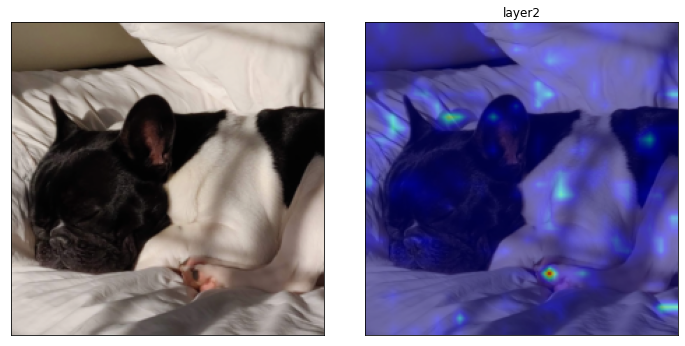

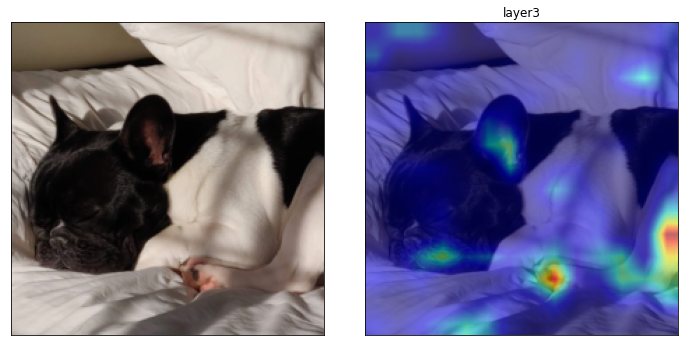

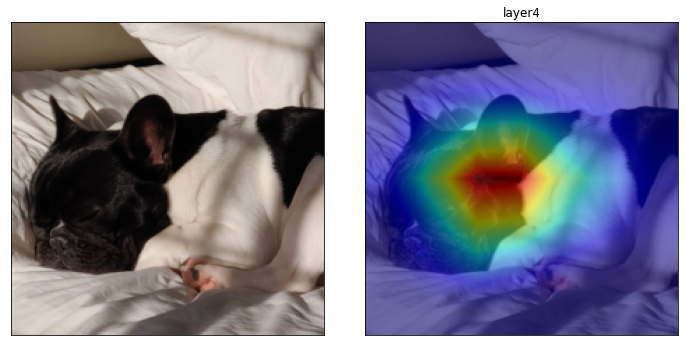

In [ ]:
from torch.nn.functional import softmax
from torchcam.methods import GradCAM

layers = ["layer2", "layer3", "layer4"]

# pasamos el modelo a CUDA (para que ande más rápido)
model = model.cuda()
# hacemos lo mismo con la imagen del perro (la que está en tensor!)
image_as_tensor = image_as_tensor.cuda()

# ponemos la red en modo evaluación
model = model.eval()
# inicializamos el GradCAM
cam_extractor = GradCAM(model, layers)
# pasamos la imagen preprocesada por el modelo
output = model(image_as_tensor)
# obtenemos lo que predijo el modelo
predicted_class = output.squeeze(0).argmax().item()
print("El modelo predijo la clase: {} (p = {:.4f})".format(image_net_labels[predicted_class], softmax(output.squeeze(0), dim=0)[predicted_class]))

# extraemos el activation map para cada bloque de la red
attributions_grad_cam = cam_extractor(predicted_class, output)
# mostramos los mapas por separado
for i, att in enumerate(attributions_grad_cam):
  visualize_cam_torchcam(preprocessed_dog_image, att, title=layers[i])

Observen que cuando usamos la "layer2", los detalles que vemos en el CAM son más chicos que al usar la "layer4". Como les comentaba antes, estamos viendo que las primeras capas ven detalles más chicos, y que las de más adentro ya empiezan a combinarlos en características más complejas y más grandes.

Si queremos verlas a todas juntas, podemos combinarlas con el método ```fuse_cam``` que nos provee TorchCAM:

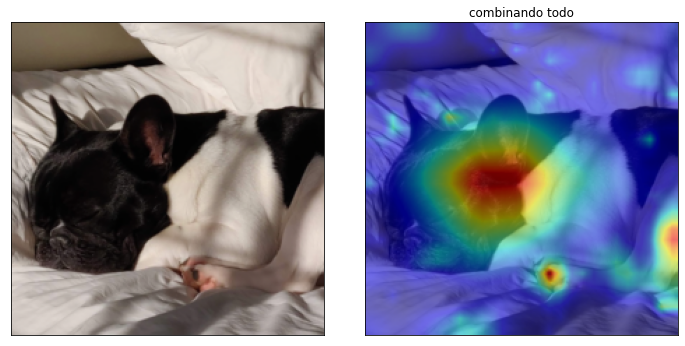

In [ ]:
# los fusionamos en un único mapa
attributions_grad_cam = GradCAM.fuse_cams(attributions_grad_cam)
# visualizamos el mapa
visualize_cam_torchcam(preprocessed_dog_image, attributions_grad_cam, title="combinando todo")

#### 2.3. Un caso más enroscado

Vamos a trabajar ahora con una imagen un poco más compleja: la mía tomando cerveza y comiendo pizza en Roma XD

En el código que tenemos acá abajo, vamos a tomar la imagen original, y nos vamos a concentrar en la parte de abajo, que es donde se ven más cosas. La vamos a partir en dos mitades, la izquierda (donde se ve el vaso de cerveza y la pizza) y la derecha (donde tenemos la pizza y una botella).

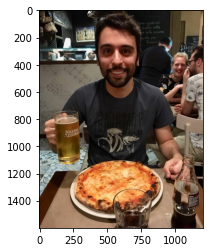

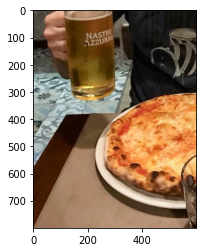

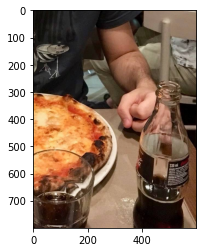

In [ ]:
# importamos las librerías para trabajar con rutas y remover archivos
from os import path, remove

import matplotlib.pyplot as plt
from PIL import Image

# por defecto, todas las imágenes van a llevar este nombre
example_filename = "image_example.png"
# si ya existía, la vamos a borrar para evitar que se nos llene la nube 
# de pavadas
if path.exists(example_filename):
  remove(example_filename)

link = "https://github.com/ignaciorlando/ignaciorlando.github.io/raw/master/datasets/roma.jpeg" # nacho hambriento y sediendo en Roma
# bajamos la imagen
wget.download(link, example_filename)

# abrimos la imagen usando PIL
pil_image = Image.open(example_filename)
# le sacamos el canal alpha (si lo tiene)
pil_image = pil_image.convert("RGB")
# recortamos solamente la parte de abajo
width, height = pil_image.size
pil_image_abajo = pil_image.crop((0, height/2, width, height))

# obtenemos sus coordenadas
width, height = pil_image_abajo.size
pil_image_abajo_izquierda = pil_image_abajo.crop((0, 0, width / 2, height))
pil_image_abajo_derecha = pil_image_abajo.crop((width / 2, 0, width, height))

# la mostramos por pantalla
plt.imshow(pil_image)
plt.show()
plt.imshow(pil_image_abajo_izquierda)
plt.show()
plt.imshow(pil_image_abajo_derecha)
plt.show()

Y ahora que ya tenemos las imágenes, vamos a poder comentar/descomentar cuál de las dos nos interesa estudiar, y observar los activation maps. Para ayudarnos a elegir la clase que nos importa, les dejé también el top-K de la red, así podemos elegir la clase que más nos gusta!

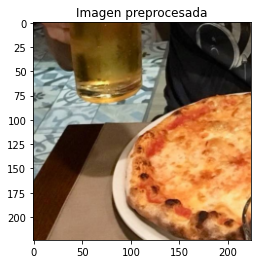

El modelo predijo la clase: pizza, pizza pie (p = 0.7478)


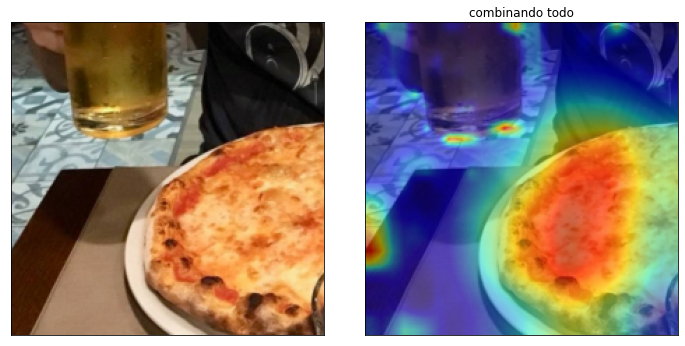

Nombre de la clase:  pizza, pizza pie  	 Nro. de clase:  963  Probabilidad: 0.7478
Nombre de la clase:  potpie  	 Nro. de clase:  964  Probabilidad: 0.2244
Nombre de la clase:  acorn squash  	 Nro. de clase:  941  Probabilidad: 0.0049
Nombre de la clase:  French loaf  	 Nro. de clase:  930  Probabilidad: 0.0037
Nombre de la clase:  burrito  	 Nro. de clase:  965  Probabilidad: 0.0034
Nombre de la clase:  cheeseburger  	 Nro. de clase:  933  Probabilidad: 0.0031
Nombre de la clase:  hotdog, hot dog, red hot  	 Nro. de clase:  934  Probabilidad: 0.0028
Nombre de la clase:  plate  	 Nro. de clase:  923  Probabilidad: 0.0022
Nombre de la clase:  bagel, beigel  	 Nro. de clase:  931  Probabilidad: 0.0014
Nombre de la clase:  frying pan, frypan, skillet  	 Nro. de clase:  567  Probabilidad: 0.0009


In [ ]:
image_elegida = pil_image_abajo_izquierda
#image_elegida = pil_image_abajo_derecha

# pasamos la imagen por las transformaciones para preprocesarla
preprocessed_image = preprocessing_ops(image_elegida)
# la mostramos por pantalla
plt.imshow(preprocessed_image)
plt.title("Imagen preprocesada")
plt.show()
# formateamos la imagen para que quede lista para la red
image_as_tensor = preprocessing_format(preprocessed_image)
# agregamos una coordenada extra para simular un batch size de 1
image_as_tensor = image_as_tensor.unsqueeze(0)

# pasamos la imagen preprocesada por el modelo
output = model(image_as_tensor.cuda())
# obtenemos lo que predijo el modelo
predicted_class = output.squeeze(0).argmax().item()
print("El modelo predijo la clase: {} (p = {:.4f})".format(image_net_labels[predicted_class], softmax(output.squeeze(0), dim=0)[predicted_class]))


# extraemos el activation map para cada bloque de la red
attributions_grad_cam = cam_extractor(predicted_class, output)
# los fusionamos en un único mapa
attributions_grad_cam = GradCAM.fuse_cams(attributions_grad_cam)
# visualizamos el mapa
visualize_cam_torchcam(preprocessed_image, attributions_grad_cam, title="combinando todo")

# vamos a pedir 10 clases
k = 10
# aplicamos top-k sobre el vector de probabilidades
probabilities, classes = torch.topk(softmax(output.squeeze(0), dim=0), k, dim=0)
# pasamos las probabilidades y clases a la memoria RAM y las convertimos en 
# vectores de numpy más fáciles de procesar
probabilities = np.squeeze(probabilities.cpu().detach().numpy())
classes = np.squeeze(classes.cpu().detach().numpy())

# iteramos por cada una de las probabilidades
for i in range(probabilities.size):
  print("Nombre de la clase: ", image_net_labels[int(classes[i])], " \t Nro. de clase: ", int(classes[i]), " Probabilidad: {:.4f}".format(float(probabilities[i])))

Y eso es todo por hoy! Con lo que vimos ya pueden empezar a debuggear sus propios modelos, para entender en qué cosas se fija y jugar un poco. En la guía práctica les proponemos algunos ejercicios extra para que se entretengan estudiando otros métodos alternativos!